In [1]:
import sys
sys.path.append("../models")
sys.path.append("../utils")
import config
import time
import numpy as np
import tensorflow as tf
import data_loader
from tra_helper.image_aug import img_missing
from tra_helper.plot_dset_one import plot_dset_one
from base_models.mobilenet import mobilenet_v2
from seg_models.unet import unet
from seg_models.unet_backbone import unet_backbone
from seg_models.deeplabv3_plus import deeplabv3_plus
from seg_models.model_triple import model_triple
from seg_models.unet_triple import unet_triple


### Training configuration

In [2]:
root_dir = '/home/yons/Desktop/developer-luo/SWatNet'
strategy = tf.distribute.MirroredStrategy()
## dataset
tra_dset = data_loader.get_tra_dset()
test_dset = data_loader.get_eva_dset()
## training configuration
optimizer = config.optimizer
loss_fun = config.binary_ce_loss
tra_loss_tracker = config.tra_loss_tracker
tra_oa = config.tra_oa
tra_miou = config.tra_miou

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


### Model loading

In [3]:
## model
#### single scale
# model = unet(nclass=2)
# model = unet_backbone(input_shape=(256,256,4), base_model=mobilenet_v2)
# model = deeplabv3_plus(input_shape=[256,256,4], base_model=mobilenet_v2, nclasses=2)
#### multiple scale
model = model_triple(input_shape=(256,256,4), base_model=mobilenet_v2)
# model = unet_triple(scale_high=2048, scale_mid=512, scale_low=256, nclass=2)
# model.summary()


In [4]:
'''------train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss_tracker.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss_tracker.result(), config.tra_oa.result(), config.tra_miou.result()

'''------test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.test_loss_tracker.update_state(loss)
    config.test_oa.update_state(y, y_pre)
    config.test_miou.update_state(y, y_pre)
    return config.test_loss_tracker.result(), config.test_oa.result(), config.test_miou.result()

'''------train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, test_dset, epochs):
    max_miou_pre = 0.8
    for epoch in range(epochs):
        start = time.time()

        '''---train the model---'''
        for x_batch, y_batch in tra_dset:
            x_batch = img_missing(x_batch)         
            # x_batch=x_batch[2]   ##!!note: x_batch[2] for single-scale model
            tra_loss_epoch,tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)

        '''---test the model---'''
        for x_batch, y_batch in test_dset:
            # x_batch=x_batch[2]  ##!note: x_batch[2] for single-scale model
            test_loss_epoch, test_oa_epoch, test_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        config.tra_loss_tracker.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.test_loss_tracker.reset_states(), config.test_oa.reset_states(), config.test_miou.reset_states()

        # '''---write into tensorboard---'''
        # train_summary_writer = tf.summary.create_file_writer(config.train_log_dir)
        # test_summary_writer = tf.summary.create_file_writer(config.test_log_dir)
        # with train_summary_writer.as_default():
        #     tf.summary.scalar('learning rate', data=config.optimizer.learning_rate(epoch*16), step=epoch)
        #     tf.summary.scalar('loss', data=tra_loss_epoch, step=epoch)
        #     tf.summary.scalar('oa', data=tra_oa_epoch, step=epoch)
        #     tf.summary.scalar('miou', data=tra_miou_epoch, step=epoch)
        # with test_summary_writer.as_default():
        #     tf.summary.scalar('loss', data=test_loss_epoch, step=epoch)
        #     tf.summary.scalar('oa', data=test_oa_epoch, step=epoch)
        #     tf.summary.scalar('miou', data=test_miou_epoch, step=epoch)
        # print the metrics
        print('epoch {}: traLoss:{:.3f}, traOA:{:.2f}, traMIoU:{:.2f}; evaLoss:{:.3f}, evaOA:{:.2f}, evaMIoU:{:.2f}, time:{:.0f}s'.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, test_loss_epoch, test_oa_epoch, test_miou_epoch, time.time() - start))
        # if test_miou_epoch>max_miou_pre:
        #     max_miou_pre = test_miou_epoch
        #     model.save_weights(config.path_savedmodel+'/unet_mobilenetv2/weights_epoch_%d'%(epoch+1))

        '''---visualize the results---'''
        if epoch%20 == 0:
            figure = plot_dset_one(model, test_dset.take(1), \
                        i_patch=np.random.randint(8), binary=False, \
                        multiscale=True, weight=False)


epoch 1: traLoss:1.476, traOA:0.65, traMIoU:0.46; evaLoss:0.637, evaOA:0.68, evaMIoU:0.34, time:179s


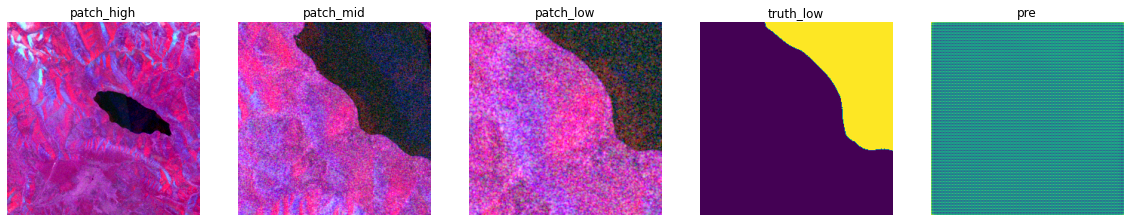

epoch 2: traLoss:0.660, traOA:0.71, traMIoU:0.50; evaLoss:0.768, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 3: traLoss:0.455, traOA:0.78, traMIoU:0.59; evaLoss:0.832, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 4: traLoss:0.478, traOA:0.75, traMIoU:0.56; evaLoss:0.777, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 5: traLoss:0.509, traOA:0.77, traMIoU:0.61; evaLoss:0.854, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 6: traLoss:0.532, traOA:0.80, traMIoU:0.66; evaLoss:0.744, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 7: traLoss:0.425, traOA:0.78, traMIoU:0.62; evaLoss:0.671, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 8: traLoss:0.500, traOA:0.84, traMIoU:0.71; evaLoss:0.657, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 9: traLoss:0.389, traOA:0.84, traMIoU:0.72; evaLoss:0.645, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 10: traLoss:0.388, traOA:0.85, traMIoU:0.71; evaLoss:0.649, evaOA:0.68, evaMIoU:0.34, time:11s
epoch 11: traLoss:0.359, traOA:0.84, traMIoU:0.69; evaLoss:0.664, evaOA:0.68, evaMIoU:0.34, time:11

In [5]:
## training
train_loops(model, loss_fun, optimizer, tra_dset, test_dset, epochs=200)


In [5]:
# %load_ext tensorboard
# !kill 6006
# %tensorboard --logdir logs/tensorb/
# http://localhost:16006


In [6]:
# model saving and loading
# path_weight = root_dir + '/models/temporal/UNet_gru_triple/weights_epoch_40'
# path_save_model = root_dir + '/models/pretrained/triple_backbone'
# model.save(path_save_model)
# model.save_weights(path_model)
# model = tf.keras.models.load_model(path_model)  ## load model
# model.load_weights(path_weight)

